# Chunking GOES data and saving to zarr
A quick notebook to download goes MCMIP data, crop it to a lon/lat bounding box and save it as zarr format

Note: downloading GOES data using the google cloud api requires you to have GCP service account credentials set up (https://console.cloud.google.com/apis/credentials/serviceaccountkey), and the environment variable GOOGLE_APPLICATION_CREDENTIALS set as the path to your service account key. See https://cloud.google.com/docs/authentication/getting-started for more details

Required modules (from conda):
google-cloud-storage numpy xarray netcdf4 zarr matplotlib pyproj 


In [1]:
import os
import sys
import inspect

from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime

import matplotlib.pyplot as plt

# code from https://stackoverflow.com/questions/279237/import-a-module-from-a-relative-path?lq=1#comment15918105_6098238 to load a realitive folde from a notebook
# realpath() will make your script run, even if you symlink it :)
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

from utils.io import find_abi_files
from utils.abi import get_abi_proj, get_abi_lat_lon

In [2]:
# Bounding and saving functions

def ll_bound(abi_ds, ll_bbox):
    geo_p = get_abi_proj(abi_ds)
    x, y = geo_p([ll_bbox[0], ll_bbox[0], ll_bbox[2], ll_bbox[2]], 
                 [ll_bbox[1], ll_bbox[3], ll_bbox[1], ll_bbox[3]])
    
    x = [xi if np.isfinite(xi) else np.nan for xi in x]
    y = [yi if np.isfinite(yi) else np.nan for yi in y]
    
    xy_bbox = (np.nanmin(x)/abi_ds.goes_imager_projection.perspective_point_height, 
               np.nanmin(y)/abi_ds.goes_imager_projection.perspective_point_height, 
               np.nanmax(x)/abi_ds.goes_imager_projection.perspective_point_height, 
               np.nanmax(y)/abi_ds.goes_imager_projection.perspective_point_height)
    
    return abi_ds.isel({'x':np.logical_and(abi_ds.x>xy_bbox[0], abi_ds.x<xy_bbox[2]),
                        'y':np.logical_and(abi_ds.y>xy_bbox[1], abi_ds.y<xy_bbox[3])})

def chunk_to_zarr(abi_ds, savepath, ll_bbox=None, mode='w'):
    if ll_bbox:
        chunk_ds = ll_bound(abi_ds, ll_bbox)
        chunk_ds.to_zarr(savepath, mode=mode)
    else:
        abi_ds.to_zarr(savepath, mode=mode)

## Test one file

In [12]:
data_path = '/gws/nopw/j04/eo_shared_data_vol2/scratch/satellite/GOES16'
save_path = './data/goes_zarr'
save_name = 'goes_test.zarr'
date = datetime(2020,7,1,18)
ll_bbox=(-85,-30,-70,-15)

In [13]:
abi_files = sorted(find_abi_files(date, satellite=16, product='MCMIP', view='F', mode=6, 
                               save_dir=data_path, 
                               replicate_path=True, check_download=True, 
                               n_attempts=1, download_missing=True))
len(abi_files)

6

([], <a list of 0 Text major ticklabel objects>)

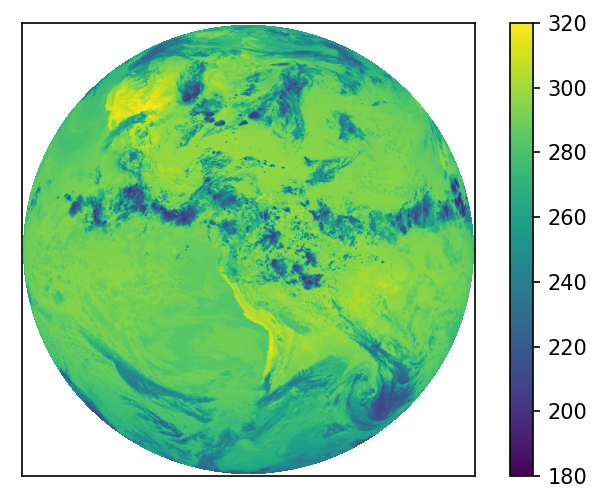

In [14]:
abi_ds = xr.open_dataset(abi_files[0])
plt.figure(dpi=150)
plt.imshow(abi_ds.CMI_C13, vmin=180, vmax=320)
plt.colorbar()
plt.xticks([])
plt.yticks([])

In [15]:
chunk_to_zarr(abi_ds, os.path.join(save_path, save_name), ll_bbox=ll_bbox)

/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


([], <a list of 0 Text major ticklabel objects>)

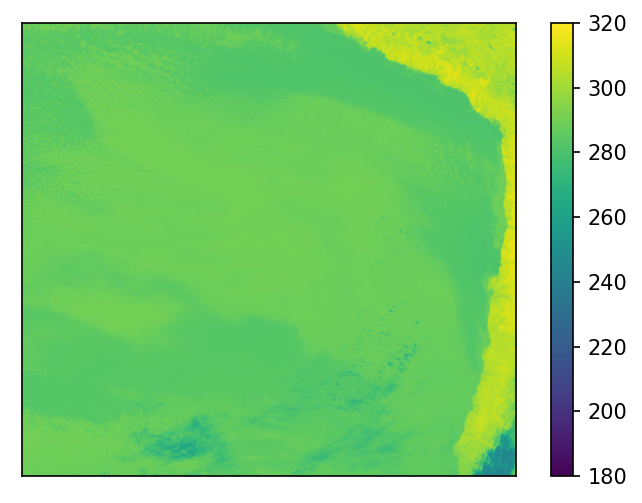

In [16]:
chunk_ds = xr.open_zarr(os.path.join(save_path, save_name))
plt.figure(dpi=150)
plt.imshow(chunk_ds.CMI_C13, vmin=180, vmax=320)
plt.colorbar()
plt.xticks([])
plt.yticks([])

## Now run over a series of files

In [11]:
data_path = '/gws/nopw/j04/eo_shared_data_vol2/scratch/satellite/GOES16'
save_path = '/work/scratch-nopw/wkjones/goes-zarr'
date = datetime(2020,7,1,18)
ll_bbox=(-85,-30,-70,-15)

dates = list(pd.date_range(datetime(2020,7,1,5), datetime(2020,7,2,4), freq='h').to_pydatetime())

for date in dates:
    abi_files = sorted(find_abi_files(date, satellite=16, product='MCMIP', view='F', mode=6, 
                               save_dir=data_path, 
                               replicate_path=True, check_download=True, 
                               n_attempts=1, download_missing=True))
    for abi_file in abi_files:
        print(abi_file, end='\r')
        with xr.open_dataset(abi_file) as abi_ds:
            save_name = os.path.join(save_path,
                                    os.path.split(os.path.splitext(abi_file)[0])[1] + '.zarr')
            chunk_to_zarr(abi_ds, save_name, ll_bbox=ll_bbox)

/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,


/home/users/wkjones/miniconda2/envs/pytorch/lib/python3.7/site-packages/xarray/core/dataset.py:1634: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  append_dim=append_dim,
